<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>TFIDF-HGBC
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

Das Modell zur Klassifikation von Disaster Tweets besteht aus zwei Hauptkomponenten: einem Vectorizer und einem Classifier.

Der Vectorizer, in diesem Fall TFIDF (Term Frequency-Inverse Document Frequency), wandelt die Tweets in numerische Vektoren<br>
um. TFIDF berechnet für jedes Wort in einem Tweet einen Wert, der angibt, wie wichtig das Wort für den Tweet ist. Dabei wird<br>
die Häufigkeit des Wortes im Tweet (Term Frequency) mit der Seltenheit des Wortes im gesamten Textkorpus (Inverse Document<br>
Frequency) multipliziert. Dieser Prozess ermöglicht es, die Tweets in einem numerischen Raum darzustellen, in dem ähnliche<br>
Tweets nahe beieinander liegen.

Nachdem die Tweets mit dem Vectorizer in Vektoren umgewandelt wurden, werden sie dem Histogram Gradient Boosting Classifier<br>
zugeführt. Dieser Classifier ist eine Erweiterung des Gradient Boosting Classifiers und verwendet Histogramme, um die<br>
Effizienz des Trainings und der Vorhersage zu verbessern. Der Classifier lernt aus den TFIDF-Vektoren und<br>
erstellt ein Modell, das in der Lage ist, neue, nicht gekennzeichnete Tweets zu klassifizieren. Dabei wird der<br>
Disaster-Status (Ja/Nein) des Tweets vorhergesagt.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import html
import scipy
import torch
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Scipy Version: {scipy.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 100

# Pandas Settings
pd.options.display.max_colwidth = None

Python Version: 3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]
PyTorch Version: 2.1.0
Numpy Version: 1.25.2
Scipy Version: 1.11.3
Pandas Version: 2.1.1
Matplotlib Version: 3.7.0
Sklearn Version: 1.3.1
Seaborn Version: 0.12.2


## Helper Functions

Hier werden Funktionen und Klassen definiert, die bei den Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.
class Pipeline:
    """Pipeline for customizable text classification model."""

    def __init__(self, vectorizer, classifier, reducer=None) -> None:
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.reducer = reducer

    def __repr__(self) -> str:
        return f"Pipeline(vectorizer={self.vectorizer}, classifier={self.classifier}, reducer={self.reducer})"

    def fit(self, features, labels) -> "Pipeline":
        """
        Fit the model to the given training data.

        Parameters
        ----------
        features : list of str
            Training data features.
        labels : np.ndarray or pandas.Series
            Training data labels.

        Returns
        -------
        self
            The fitted model.
        """
        self.vectorizer.fit(features)
        transformed_features = self.vectorizer.transform(features).toarray()
        if self.reducer:
            self.reducer.fit(transformed_features)
            transformed_features = self.reducer.transform(transformed_features)
        self.classifier.fit(transformed_features, labels)
        return self

    def predict(self, features) -> np.ndarray:
        """
        Predict labels for the given features.

        Parameters
        ----------
        features : list of str
            Features to predict labels for.

        Returns
        -------
        np.ndarray
            Predicted labels for the given features.
        """
        transformed_features = self.vectorizer.transform(features).toarray()
        if self.reducer:
            transformed_features = self.reducer.transform(transformed_features)
        return self.classifier.predict(transformed_features)

    def score(self, features, labels, metric="acc") -> np.float64:
        """
        Score the model on the given features and labels.

        Parameters
        ----------
        features : list of str
            Features to score the model on.
        labels : np.ndarray or pandas.Series
            Labels to score the model on.
        metric : str, optional
            Metric to use for scoring, by default "acc"

        Returns
        -------
        np.float64
            Score of the model on the given features and labels.
        """
        match metric:
            case "acc":
                return sklearn.metrics.accuracy_score(labels, self.predict(features))
            case "f1_macro":
                return sklearn.metrics.f1_score(labels, self.predict(features), average="macro")
            case _:
                raise ValueError(f"Unknown metric: {metric}")
            
    def validate(self,  features, labels) -> None:
        """
        Validate the model on the given features and labels.

        Parameters
        ----------
        features : list of str
            Features to validate the model on.
        labels : np.ndarray or pandas.Series
            Labels to validate the model on.
        """
        predicted_labels = self.predict(features)

        print("Metrics")
        print(f"Accuracy: {self.score(features, labels, metric='acc')}")
        print(f"F1 Macro: {self.score(features, labels, metric='f1_macro')}")
        print()

        print("Confusion Matrix")
        conf_matrix = sklearn.metrics.confusion_matrix(labels, predicted_labels).astype(int)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', cbar=False,
                    xticklabels=['Predicted False', 'Predicted True'],
                    yticklabels=['Actual False', 'Actual True'],
                    annot_kws={"size": 16})
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        print()

        print("ROC Curve")
        probs = self.classifier.predict_proba(self.vectorizer.transform(features).toarray())
        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, probs[:, 1])
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        print()

        print(f"Some first degree errors (predicted true, actual false)), Total: {np.sum((predicted_labels == 1) & (labels == 0))}")
        first_degree_errors = np.where((predicted_labels == 1) & (labels == 0))[0]
        first_degree_errors = pd.DataFrame({'Text': [features[i] for i in first_degree_errors],})
        display(first_degree_errors.sample(10))
        print()

        print(f"Some second degree errors (predicted false, actual true)), Total: {np.sum((predicted_labels == 0) & (labels == 1))}")
        second_degree_errors = np.where((predicted_labels == 0) & (labels == 1))[0]
        second_degree_errors = pd.DataFrame({'Text': [features[i] for i in second_degree_errors],})
        display(second_degree_errors.sample(10))
        

## Einlesen des verarbeiteten Datensatzes

In [3]:
train = pd.read_csv('data/processed/train.csv', index_col=0)
val = pd.read_csv('data/processed/val.csv', index_col=0)

X_train = [html.unescape(tweet) for tweet in train["text"]]
X_val = [html.unescape(tweet) for tweet in val["text"]]

y_train = train["target"]
y_val = val["target"]

Wir lesen die getrennten Datensätze ein und wandeln alle vorhandenen HTML Sonderzeichen in normale Zeichen um.<br>
In unseren X Arrays befinden sich die Sätze untokenisiert. Der TFIDF Vectorizer "tokenisiert" die Sätze automatisch.


## Trainieren des Klassifikationsmodell

In [4]:
# Define Pipeline
TFIDF_HGBC = Pipeline(
    vectorizer=TfidfVectorizer(max_features=1000),
    reducer=None, # None, PCA, NMF, etc.
    classifier=HistGradientBoostingClassifier(),
)

# Fit Pipeline
TFIDF_HGBC.fit(X_train, y_train)

Pipeline(vectorizer=TfidfVectorizer(max_features=1000), classifier=HistGradientBoostingClassifier(), reducer=None)

Für das Trainieren des Modells wird der TFIDF Vectorizer verwendet, um die Sätze in Matrizen umzuwandeln. <br>
Die Matrizen werden dann in den HGBC gegeben, um das Modell zu trainieren. <br>

Zwischen TFIDF Vectorizer und HGBC besteht die Option, eine Dimensionsreduktion durchzuführen. <br>
Jedoch ist dies in vielen Fällen langsamer und führt zu schlechteren Ergebnissen. <br>
Alternativ kann man dem Vectorizer mitteilen, nur die 1000 wichtigsten Wörter zu verwenden.<br> 
Dies führt erstaunlicherweise nicht zu schlechteren Ergebnissen. Möglicherweise wegen der Simplizität unseres Datensatzes.<br>

## Auswertung des Klassifikationsmodell

TODO: Welche Metriken und wieso passen diese (zum Anwenungsfall)?

Als erstes Überprüfen wir unser Modell auf den Trainingsdaten.

Metrics
Accuracy: 0.8785905143620575
F1 Macro: 0.8726912122996648

Confusion Matrix


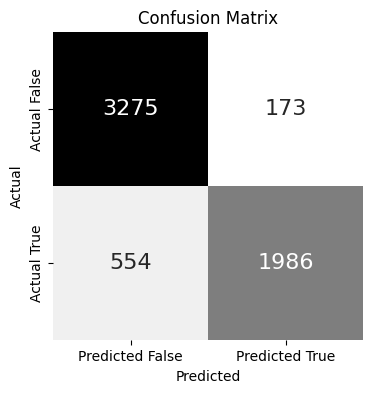


ROC Curve


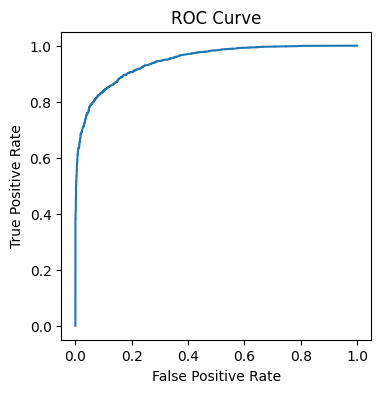


Some first degree errors (predicted true, actual false)), Total: 173


,Text
155,Brunette teen Giselle Locke teases at home http://t.co/qew4c5M1xd View and download video
144,she's a suicide bomb
101,I'm hungry as a hostage
127,Any lengths to rescue a cat in need! http://t.co/AMroX4Y4Nx
140,ice cream + cupcake wars + storm = content sara
138,Nike Golf Storm Fit Golf Jacket Black Medium http://t.co/jvAI5Vkmsy: #SportingGoods http://t.co/Nr8JjmpmoS
42,#fitness Knee Damage Solution http://t.co/pUMbrNeBJE
15,kou is like [CASH REGISTER] [BUILDINGS BURNING]
126,Newlyweds feed thousands of Syrian refugees instead of hosting a banquet wedding dinner http://t.co/EGcv7ybjae #Age #news
65,FAAN orders evacuation of abandoned aircraft at MMA http://t.co/dEvYbnVXGQ via @todayng



Some second degree errors (predicted false, actual true)), Total: 554


,Text
479,Slums are a manifestation state failure to provide housing to citizens. Illegality discourse confounds structural problems. #stopevictions
81,?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/iap4LwvqsW
77,Bloody insomnia again! Grrrr!! #Insomnia
208,@freeMurphy Your hot take on Canada's hitchhiking garbage-bot (destroyed in Philly) was sorely needed.
319,@TheBlackshag @dannyoneil too toxic...cancer....disease...hazardous waste...noxious...
326,Fel Lord Zakuun is about to DIE ! #Hellfire #WOD http://t.co/x1oNV3d5uX
248,@POTUS Thx for emergency dec. http://t.co/DyWWNbbYvJ 4 days and no plan to get H20 to those who have no transport. Can you deploy troops?
324,@rachelcaine The weatherit needs to make it minds up. First snow tornadoes now would you say a heat wave?
398,This is the natural and unavoidable consequence of socialism everywhere it has been tried.\nhttp://t.co/BbDpnj8XSx A
120,ok peace I hope I fall off a cliff along with my dignity


In [5]:
TFIDF_HGBC.validate(X_train, y_train)

Beim Auswerten des Modells auf den Trainingsdaten erreichen wir recht hohe Metriken. Das Modell macht aber sehr viele Fehler zweiten Grades.<br>
Wenn man aber die falsch klassifizierten Sätze sieht, sehen wir ein komisches Muster:<br>
Einige Sätze, welche als Katastrophe klassifiziert werden, sehen nicht gerade nach Katastrophen aus oder können nur nach Einsicht eines Links so <br>klassifiziert werden. <br><br>
Zum Beispiel:<br> 
"@freeMurphy Your hot take on Canada's hitchhiking garbage-bot (destroyed in Philly) was sorely needed."<br>
"ok peace I hope I fall off a cliff along with my dignity"<br>
"This is the natural and unavoidable consequence of socialism everywhere it has been tried.http://t.co/BbDpnj8XSx A"<br><br>
Bei den Fehlern ersten Grades kann man schon besser nachvollziehen, wieso das Modell diese falsch klassifiziert hat. <br>
Wörter wie "hostage", "suicide bomb" oder "wars" werden genutzt, um einen Satz dramatischer wirken zu lassen. <br>
Das Modell hat Schwierigkeiten, diese Zusammenhänge im Kontext korrekt zu erkennen.

Metrics
Accuracy: 0.7755511022044088
F1 Macro: 0.7650141087212452

Confusion Matrix


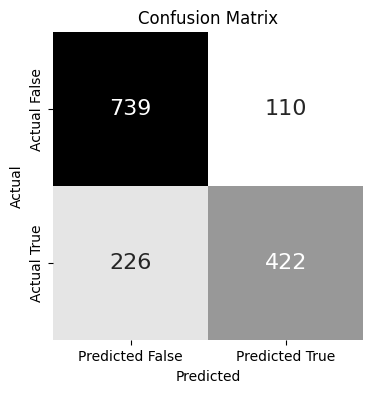


ROC Curve


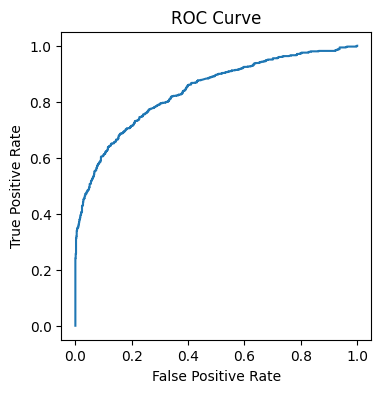


Some first degree errors (predicted true, actual false)), Total: 110


,Text
27,Worlds Collide When an American Family Takes Over Britain's Isle of Man in New TLC Show Suddenly Royal http://t.co/OmB3oS54tN via @People
69,@kristenKOIN6 Yay good cooler weather for PDX..ABQ NM is feeling the heat wave now bcuz my rain dances aren't working :-)
106,and I thought my surgical wounds were healed!!! this weather ain't helping either ):
34,Photoshop Tools Crash Course - Complete Photoshop Tool Guide http://t.co/DunMvj7ITl #course http://t.co/RgdrJv63hF
65,USFS an acronym for United States Fire Service. http://t.co/8NAdrGr4xC
63,when fizzy is sitting in the regular flood seats ...... and no one knows who she is.....
18,@LasVegasLocally @VitalVegas They reined it in to 3 drinks each for 2 people but only on account of too many falling-off-stool casualties!
74,Hurricane Dancers: The First Caribbean Pirate Shipwreck\nMargarita Engle - Henry Holt and Co. (BYR). http://t.co/i7EskymOec
7,I know where to go when the zombies take over!! http://t.co/hUTHXlkyxy
92,sorry-I built a fire by my desk already. RT@irishirr\n@MChapmanWSAZ @WSAZ_Brittany @kellyannwx ..please maintain that snowstorm til I arrive.



Some second degree errors (predicted false, actual true)), Total: 226


,Text
15,@DarrellIssa Does that 'great Iran deal' cover bioterrorism? You got cut off terrible of them. Keep up the good work.
211,Lol\nLook how tough some people talk that live in some of the most gang infested cities in America\nYour mouth isn't a weapon\nYou fucking wimp
52,@HfxStanfield @beelieveDC @DiscoveryCntr what is happening we hear there is runway lighting damage by a contractor.
51,Talent: Misdirection Cyclone Pass Ignite Pass Vanishing Drive Phantom Shot #KurokoBot
26,Ton of smoke coming out of one of the new apartment buildings at 160 Ross in Auburn. Several fire trucks on scene. http://t.co/AHVYmSQHqC
190,@AsimTanvir @NemesisK_PES @KevR_7 Snow? Thunder and lightning?
171,I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-
57,don't get on I77 south... huge wreck and airlift and maybe some deaths interstate is completely blocked
42,Petition | Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now! http://t.co/87eFCBIczM
40,Now that's what you call a batting collapse #theashes


In [6]:
TFIDF_HGBC.validate(X_val, y_val)

Beim Auswerten des Modells auf den Validierungsdaten sehen wir, dass die Scores deutlich zum Trainingsdatensatz gesunken sind, <br>jedoch noch gute Ergebnisse zeigen.<br>

Hier ist das Ausmass der Fehler zweiten Grades verglichen zu den Fehlern ersten Grades etwas kleiner als bei der Validierung mit den Trainingsdaten.<br>
Viele Fehler zweiten Grades sind hier sehr warhscheinlich Antworten zu Threads, welche Katastrophenrelevant sind. <br>
Dies macht diese Klassifikation unglaublich schwierig, da der Kontext dafür einfach fehlt.

Zum Beispiel:<br> 
"@AsimTanvir @NemesisK_PES @KevR_7 Snow? Thunder and lightning?"<br>
"I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-"<br>
"@DarrellIssa Does that 'great Iran deal' cover bioterrorism? You got cut off terrible of them. Keep up the good work."<br>

Bei den Fehlern ersten Grades ziehe ich die gleichen Erkenntnisse wie bei der vorherigen Validierung.<br>
Es sieht so aus als würden einige Triggerwords wi z.B. "**Crash**" (von Crash Course) das Modell stark beinflussen.

TODO: Metriken kommentieren.

## Erkenntnisse

TODO: Alle Erkenntnisse zusammentragnen.

## Fazit

TODO: Bei den anderen abschauen.

## Kaggle Submission

Hier lassen wir noch die Testdaten durch das Modell laufen und speichern die Ergebnisse in einer CSV Datei.<br>
Diese kann bei der Kaggle Competition hochgeladen werden.

In [ ]:
kaggle_test = pd.read_csv('data/processed/test.csv', index_col="id", encoding="utf-8")
X_test = [html.unescape(tweet) for tweet in kaggle_test["text"]]

submisson = TFIDF_HGBC.predict(X_test)
submisson = pd.DataFrame(submisson, index=kaggle_test.index, columns=["target"])
submisson.to_csv("data/submissions/TFIDF_HGBC.csv", index=True, index_label="id")